In [1]:
import pandas as pd
from statsmodels.stats.contingency_tables import cochrans_q, mcnemar
import statsmodels.stats
import scipy.stats
import numpy as np
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import matplotlib

In [2]:
THRESHOLD = 0.05 #alpha significance level
PREDICTIONS_DIR = 'predictions'

tasks = {
    'binary': [0, 1], 
    'type': [0, 1, 2, 3]
}
representations = ['bow', 'freq', 'tfidf']
models = ['decision-tree', 'svm', 'naive-bayes', 'xgboost']
methods = ['RandomUnder', 'SMOTETomek', 'RandomOver', 'ADASYN', 'none', 'aug']

In [3]:
#find the mode of a numpy array
def mode(array):
    freq = np.bincount(array)
    return np.argmax(freq)

In [4]:
def shorten_name(name):
    shortenings = {
    'decision-tree': 'dt',
    'naive-bayes-multinomial': 'nbm',
    'naive-bayes': 'nb',
    'xgboost': 'xgb',
    '-classification': '',
    '-type_of_antisemitism': '',}
    for long_version in shortenings:
        name = name.replace(long_version, shortenings[long_version])
    return name

#visualize the results of a post-hoc dunn analysis on a cochran's q test using matplotlib in a matrix
def visualize_dunn(dunn_values, names):
    names = [shorten_name(name) for name in names]
    
    plt.matshow(dunn_values)
    ax = plt.gca()
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    ax.set_xticklabels(labels=names,rotation=90)
    ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    ax.set_yticklabels(labels=names)
    
    #pulled these next two lines from stack overflow, just to display the values
    for (i, j), z in np.ndenumerate(dunn_values):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
        
    plt.pause(0.1)

In [5]:
#find the raw accuracy scores of all of the columns
def find_accuracy(df):
    accuracies = [1,]
    for column in [column for column in df.columns.values if column != 'Actual']:
        df[column] = df.apply(lambda x: int(x[column] == x['Actual']), axis=1)
        accuracies.append(df[column].mean())
    return accuracies

In [6]:
#combine columns in a dataframe whose names contain certain substrings
def combine_columns(df, substrings):
    '''
    df: the input dataframe that has many column names that contain certain common substrings
    substrings: the list of substrings used for combination
    
    returns: `output_df`, a DataFrame with `substrings` as its columns. Each row is the mode
    of the value for that row of all of the columns in `df` that contained that substring.
    '''
    output_df = pd.DataFrame()
    
    for column_substring in substrings:
        temp_df = pd.DataFrame()
        to_be_combined = [column for column in df.columns.values if column_substring in column]
        
        for column in to_be_combined:
            temp_df[column] = df[column]
            
        array = np.array(temp_df).astype(int)
        array = [mode(row) for row in array]
            
        output_df[column_substring] = array
    
    return output_df

In [7]:
#find which models performed best using basic accuracy score
def evaluate_models(df, substrings):
    output_df = pd.DataFrame()
    temp_df = combine_columns(df, substrings)
    for column in substrings:
        temp_df[column] = temp_df[column] == df['Actual']
        output_df[column] = [sum(temp_df[column])/len(temp_df),]
    output_df.index = ['Score']
    if 'index' in output_df.columns.values: del output_df['index']
    return output_df

#test model significance difference w/ Friedman Chi^2 while combining certain columns
def test_model_difference(df, substrings):
    df = combine_columns(df, substrings)
    columns = [df[substring] for substring in substrings]
    cochran_result = cochrans_q(columns)
    return cochran_result

def post_hoc_tests(df, substrings):
    df = combine_columns(df, substrings)
    columns = [df[substring] for substring in substrings]
    p_values = sp.posthoc_dunn(columns)
    return p_values

In [8]:
#get a list of binary dfs of whether or not they fit with a particular classification
def get_dfs(df, classifications):
    dfs = []
    for classification in classifications:
        temp_df = df[df['Actual'] == classification]
        temp_df = temp_df.reset_index()
        dfs.append(temp_df)
    return dfs

#find specific rankings for each model
def overall_evaluation(task, classifications, method):
    df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-{method}.csv')
    score_df = pd.DataFrame()
    dfs = get_dfs(df, classifications)
        
    for (i, temp_df) in enumerate(dfs):
        temp_df = evaluate_models(temp_df, temp_df.columns.values).transpose()
        temp_df = temp_df.sort_values('Score', ascending=False)
            
        score_df[f'Score {i}'] = temp_df['Score']
    
    score_df['Mean score'] = score_df.mean(axis=1)
    score_df['Accuracy'] = find_accuracy(df)
    score_df = score_df.sort_values('Mean score', ascending = False)
    cochran_result = cochrans_q(df)
    post_hoc_p = pd.DataFrame()
    if cochran_result.pvalue <= THRESHOLD:
        post_hoc_p = post_hoc_tests(df, df.columns.values)
    
    print(f'Task: {task}.')
    print(f"Cochran's Q test p-value: {cochran_result.pvalue}")
    if cochran_result.pvalue <= THRESHOLD:
        print('Post-hoc Dunn test array:')
        visualize_dunn(post_hoc_p, df.columns.values)
    
    score_df.index = [shorten_name(name) for name in score_df.index]
    print(score_df)
    print(f'\nMean: {score_df["Mean score"].mean()}')
    print('\n\n')
    return score_df

In [9]:
def evaluate_rep_model(grouping, dfs):
    final_df = pd.DataFrame()
    
    for i, df in enumerate(dfs):
        temp_df = evaluate_models(df, grouping).transpose()
        temp_df = temp_df.sort_values('Score', ascending=False)
        
        temp_df.columns = ['Score']
        final_df[f'Score {i}'] = temp_df['Score']
        
    return final_df

#evaluate algorithms and representations, find significance level
def algorithm_and_rep_eval(task, classifications, method):
    df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-{method}.csv')
    dfs = []
    for classification in classifications:
        temp_df = df[df['Actual'] == classification]
        temp_df = temp_df.reset_index()
        dfs.append(temp_df)
    for grouping in [representations, models]:
        score_df = evaluate_rep_model(grouping, dfs)
        score_df['Mean score'] = score_df.mean(axis=1)
        score_df = score_df.sort_values('Mean score', ascending = False)
        
        combined_df = combine_columns(df, grouping)
        cochran_result = cochrans_q(combined_df)
        if cochran_result.pvalue <= THRESHOLD:
            post_hoc_p = post_hoc_tests(combined_df, grouping)
        
        print(f'Task: {task}. Grouping: {grouping}.')
        print(f"Cochran's Q test p-value: {cochran_result.pvalue}")
        if cochran_result.pvalue <= THRESHOLD:
            print('Post-hoc Dunn test array:')
            visualize_dunn(post_hoc_p, grouping)
        
        score_df.index = [shorten_name(name) for name in score_df.index]
        print(f"Scores: \n{score_df}")
        print(f'\nMean: {score_df["Mean score"].mean()}')
        print('\n\n')

In [10]:
#evaluate the overall resampling methods, perform friedman test and post-hoc nemenyi
def evaluate_resampling(overall_df, indeces):
    columns = [overall_df[column] for column in overall_df.columns.values]
    statistic, pvalue = scipy.stats.friedmanchisquare(*columns)
    overall_df.loc[len(overall_df)] = overall_df.apply(lambda x: np.mean(x))
    indeces.append('Mean')
    overall_df.index = indeces
    print('\nOverall scores:')
    print(f'Friedman Chi Square Statistic: {statistic}. p-value: {pvalue}.')
    print(overall_df)
    if pvalue <= THRESHOLD:
        overall_df = overall_df.transpose()
        columns = [overall_df[column] for column in overall_df.columns.values]
        p_values = sp.posthoc_nemenyi_friedman(columns)
        print('\nPost-hoc Dunn test array:')
        visualize_dunn(p_values, list(overall_df.index))

The below visualizations and `DataFrame`s contain testing information on the various algorithms and representation methods used to create models. Data is shown on two tasks, 'binary,' referring to the binary classification of whether or not a particular tweet is antisemitic, and 'type,' referring to classifying the tweet with a particular type of antisemitism. The model evaluation was done in two stages, first the overall evaluation, then the grouped evaluation for different algorithms and representations. Some names are shortened during presentation: `decision-tree` is shortened to `dt`, `naive-bayes-multinomial` to `nbm`, and `naive-bayes` to `nb`.

For the overall evaluation, the model scores were generated using the arithmetic mean of the recalls on each individual class, with a Cochran's Q test being performed on a matrix that contained columns for each model and in each column contained a `1` where the model found the correct answer, and `0` where the model found the incorrect answer. Then, if the Q test found an *p*-value lower than the specified global `THRESHOLD` constant, it performs a post-hoc Dunn text, which is then visualized in the form of a matrix, with higher values meaning lighter colors and a greater correlation between two models' answers. Then, the score `DataFrame` is shown, with a column entitled `Mean score` for the arithmetic mean of the recall of the model on each class. There are additional columns entitles `Score {x}`, with `{x}` being the specific class that that column gives the recall of for each model. Finally, an overall mean of the `Mean score` column is given.

For the model grouping evaluation, models are grouped into classes either by their representation or algorithm type. The most common answer across all models of this type is then taken as the answer for this grouping. Following this, the same process as above was used.

In [11]:
def task_eval(task):
    print(f'\nTask: {task.title()}\n')
    overall_df = pd.DataFrame()
    indeces = []
    for method in methods:
        print(f'\nMethod: {method}\n')
        temp_df = overall_evaluation(task, tasks[task], method) #find the rankings for all models
        if not indeces:
            indeces = list(temp_df.index)
        overall_df[method] = temp_df['Mean score']
        #algorithm_and_rep_eval(task, tasks[task], method) #group representations and algorithms together, evaluate
    evaluate_resampling(overall_df, indeces)


Task: Binary


Method: RandomUnder

Task: binary.
Cochran's Q test p-value: 3.2066928201082007e-260
Post-hoc Dunn test array:


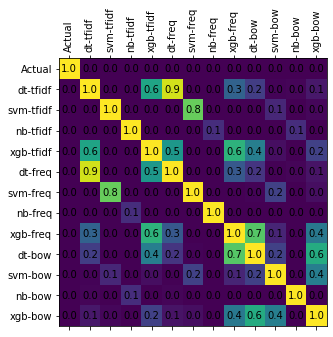

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.724886  0.651163    0.688024  0.573770
xgb-bow    0.710046  0.633721    0.671883  0.663115
svm-tfidf  0.831050  0.491279    0.661165  0.652459
xgb-tfidf  0.668950  0.648256    0.658603  0.678689
svm-freq   0.821918  0.494186    0.658052  0.735246
dt-bow     0.706621  0.607558    0.657090  0.650820
xgb-freq   0.691781  0.622093    0.656937  0.729508
nb-bow     0.563927  0.703488    0.633708  0.704098
dt-tfidf   0.687215  0.563953    0.625584  0.544262
dt-freq    0.687215  0.558140    0.622677  0.672131
nb-freq    0.474886  0.720930    0.597908  0.688525
nb-tfidf   0.543379  0.651163    0.597271  0.603279

Mean: 0.6714539376414177




Method: SMOTETomek

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


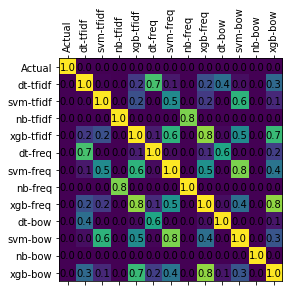

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.795662  0.543605    0.669633  0.710656
svm-tfidf  0.821918  0.508721    0.665319  0.683607
xgb-bow    0.760274  0.555233    0.657753  0.706557
svm-freq   0.800228  0.514535    0.657382  0.421311
xgb-freq   0.792237  0.488372    0.640305  0.719672
xgb-tfidf  0.803653  0.473837    0.638745  0.733607
dt-bow     0.721461  0.523256    0.622359  0.665574
dt-tfidf   0.792237  0.406977    0.599607  0.676230
dt-freq    0.788813  0.389535    0.589174  0.426230
nb-bow     0.466895  0.625000    0.545947  0.724590
nb-freq    0.281963  0.793605    0.537784  0.702459
nb-tfidf   0.283105  0.773256    0.528180  0.511475

Mean: 0.6424760661977928




Method: RandomOver

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


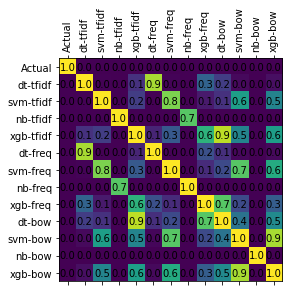

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.765982  0.593023    0.679502  0.700000
xgb-bow    0.775114  0.558140    0.666627  0.702459
svm-freq   0.804795  0.517442    0.661118  0.728689
svm-tfidf  0.824201  0.485465    0.654833  0.673770
dt-bow     0.765982  0.531977    0.648979  0.693443
xgb-tfidf  0.788813  0.482558    0.635685  0.447541
xgb-freq   0.769406  0.500000    0.634703  0.723770
nb-bow     0.528539  0.706395    0.617467  0.717213
dt-tfidf   0.770548  0.427326    0.598937  0.670492
dt-freq    0.767123  0.424419    0.595771  0.440984
nb-tfidf   0.311644  0.793605    0.552624  0.578689
nb-freq    0.300228  0.799419    0.549823  0.713934

Mean: 0.6535439181186236




Method: ADASYN

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


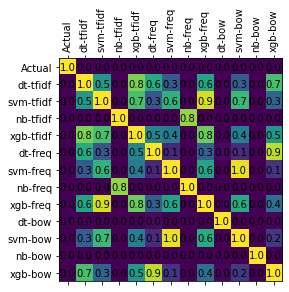

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.745434  0.601744    0.673589  0.705738
svm-tfidf  0.734018  0.601744    0.667881  0.414754
svm-freq   0.759132  0.569767    0.664450  0.674590
xgb-bow    0.711187  0.590116    0.650652  0.695082
xgb-freq   0.765982  0.514535    0.640258  0.689344
xgb-tfidf  0.778539  0.462209    0.620374  0.410656
dt-bow     0.655251  0.566860    0.611056  0.630328
dt-tfidf   0.804795  0.377907    0.591351  0.684426
dt-freq    0.783105  0.398256    0.590680  0.696721
nb-bow     0.456621  0.622093    0.539357  0.704918
nb-freq    0.261416  0.805233    0.533324  0.677049
nb-tfidf   0.262557  0.787791    0.525174  0.503279

Mean: 0.6390881670628404




Method: none

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


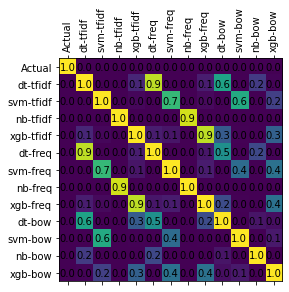

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.918950  0.415698    0.667324  0.474590
xgb-bow    0.869863  0.415698    0.642780  0.722131
nb-bow     0.704338  0.563953    0.634146  0.777049
svm-tfidf  0.940639  0.325581    0.633110  0.767213
xgb-freq   0.863014  0.372093    0.617553  0.759016
dt-bow     0.811644  0.421512    0.616578  0.701639
xgb-tfidf  0.864155  0.360465    0.612310  0.688525
svm-freq   0.949772  0.273256    0.611514  0.690984
dt-freq    0.813927  0.369186    0.591556  0.724590
dt-tfidf   0.823059  0.354651    0.588855  0.472951
nb-tfidf   0.361872  0.761628    0.561750  0.664754
nb-freq    0.359589  0.761628    0.560608  0.741803

Mean: 0.6413911828852894




Method: aug

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


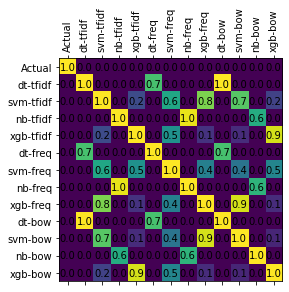

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.791096  0.578488    0.684792  0.700820
xgb-bow    0.736301  0.604651    0.670476  0.713934
xgb-freq   0.811644  0.520349    0.665996  0.459016
svm-tfidf  0.813927  0.497093    0.655510  0.724590
xgb-tfidf  0.785388  0.485465    0.635427  0.640984
svm-freq   0.816210  0.453488    0.634849  0.633607
dt-bow     0.668950  0.543605    0.606277  0.633607
dt-freq    0.695205  0.502907    0.599056  0.459836
dt-tfidf   0.683790  0.505814    0.594802  0.729508
nb-freq    0.309361  0.843023    0.576192  0.699180
nb-tfidf   0.309361  0.840116    0.574739  0.468852
nb-bow     0.343607  0.787791    0.565699  0.731148

Mean: 0.6510627261662623




Overall scores:
Friedman Chi Square Statistic: 22.809523809523803. p-value: 0.00036707369216075757.
           RandomUnder  SMOTETomek  RandomOver    ADASYN      none       aug
Actual        1.000000    1.000000    1.000000  1.000000  1.00000

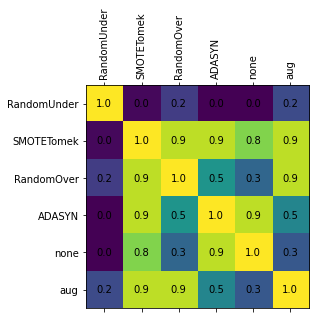

In [12]:
task_eval('binary')


Task: Type


Method: RandomUnder

Task: type.
Cochran's Q test p-value: 5.684879652185987e-309
Post-hoc Dunn test array:


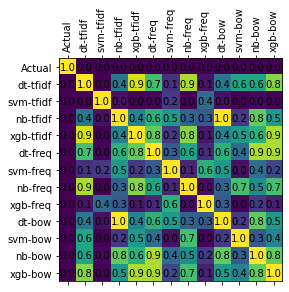

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
xgb-tfidf  0.376471    0.375  0.666667  0.235772    0.413477  0.305882
svm-bow    0.411765    0.375  0.512821  0.300813    0.400100  0.252941
dt-tfidf   0.358824    0.250  0.717949  0.260163    0.396734  0.367647
nb-bow     0.405882    0.250  0.641026  0.162602    0.364877  0.329412
svm-freq   0.352941    0.375  0.538462  0.162602    0.357251  0.382353
dt-bow     0.417647    0.375  0.461538  0.162602    0.354197  0.361765
nb-freq    0.358824    0.125  0.410256  0.382114    0.319048  0.288235
dt-freq    0.394118    0.125  0.512821  0.243902    0.318960  0.358824
xgb-bow    0.358824    0.125  0.435897  0.333333    0.313264  0.329412
xgb-freq   0.305882    0.250  0.461538  0.211382    0.307201  0.341176
svm-tfidf  0.294118    0.250  0.512821  0.113821    0.292690  0.352941
nb-tfidf   0.376471    0.000  0.512821  0.227642    0.279233  0.347059

Mean:

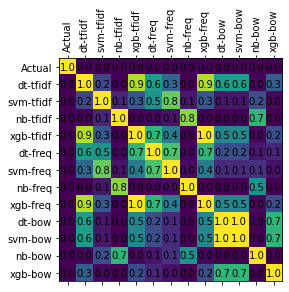

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
nb-bow     0.488235    0.500  0.564103  0.121951    0.418572  0.502941
xgb-bow    0.582353    0.125  0.564103  0.398374    0.417457  0.438235
svm-tfidf  0.488235    0.125  0.846154  0.186992    0.411595  0.364706
dt-bow     0.600000    0.125  0.589744  0.317073    0.407954  0.461765
svm-bow    0.594118    0.125  0.435897  0.373984    0.382250  0.411765
svm-freq   0.511765    0.000  0.717949  0.235772    0.366371  0.485294
dt-tfidf   0.588235    0.000  0.564103  0.284553    0.359223  0.347059
xgb-freq   0.564706    0.000  0.487179  0.325203    0.344272  0.338235
xgb-tfidf  0.570588    0.000  0.461538  0.325203    0.339332  0.423529
dt-freq    0.588235    0.000  0.487179  0.243902    0.329829  0.455882
nb-tfidf   0.529412    0.375  0.282051  0.113821    0.325071  0.455882
nb-freq    0.511765    0.375  0.307692  0.105691    0.325037  0.485294

Mean:

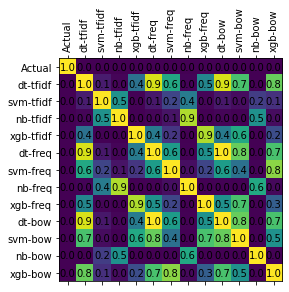

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
svm-bow    0.600000    0.250  0.641026  0.211382    0.425602  0.441176
dt-bow     0.552941    0.250  0.589744  0.260163    0.413212  0.338235
xgb-bow    0.535294    0.250  0.589744  0.243902    0.404735  0.470588
svm-freq   0.552941    0.000  0.641026  0.195122    0.347272  0.420588
nb-bow     0.452941    0.500  0.282051  0.130081    0.341268  0.317647
xgb-tfidf  0.594118    0.000  0.358974  0.382114    0.333801  0.370588
xgb-freq   0.558824    0.000  0.358974  0.414634    0.333108  0.344118
svm-tfidf  0.441176    0.000  0.692308  0.195122    0.332152  0.429412
nb-tfidf   0.505882    0.375  0.282051  0.138211    0.325286  0.455882
nb-freq    0.511765    0.375  0.307692  0.105691    0.325037  0.444118
dt-tfidf   0.552941    0.000  0.384615  0.333333    0.317722  0.476471
dt-freq    0.552941    0.000  0.358974  0.349593    0.315377  0.444118

Mean:

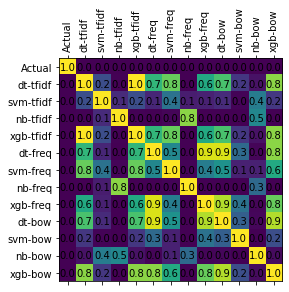

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
nb-bow     0.476471    0.500  0.794872  0.113821    0.471291  0.470588
dt-bow     0.670588    0.125  0.282051  0.292683    0.342581  0.352941
nb-tfidf   0.529412    0.375  0.307692  0.121951    0.333514  0.517647
xgb-bow    0.641176    0.125  0.205128  0.341463    0.328192  0.344118
nb-freq    0.529412    0.375  0.307692  0.097561    0.327416  0.382353
svm-bow    0.735294    0.125  0.025641  0.398374    0.321077  0.461765
dt-freq    0.676471    0.000  0.282051  0.300813    0.314834  0.414706
dt-tfidf   0.623529    0.000  0.307692  0.317073    0.312074  0.482353
xgb-freq   0.664706    0.000  0.230769  0.341463    0.309235  0.461765
xgb-tfidf  0.647059    0.000  0.230769  0.308943    0.296693  0.450000
svm-tfidf  0.547059    0.125  0.000000  0.382114    0.263543  0.476471
svm-freq   0.652941    0.000  0.000000  0.341463    0.248601  0.479412

Mean:

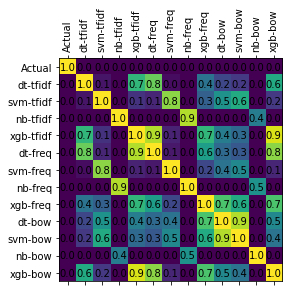

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
dt-bow     0.741176    0.125  0.358974  0.317073    0.385556  0.497059
nb-bow     0.458824    0.500  0.307692  0.105691    0.343052  0.500000
xgb-freq   0.694118    0.000  0.282051  0.373984    0.337538  0.341176
xgb-bow    0.664706    0.000  0.307692  0.365854    0.334563  0.529412
nb-tfidf   0.517647    0.375  0.307692  0.121951    0.330573  0.314706
nb-freq    0.523529    0.375  0.307692  0.097561    0.325946  0.535294
xgb-tfidf  0.705882    0.000  0.230769  0.325203    0.315464  0.491176
svm-freq   0.829412    0.000  0.000000  0.414634    0.311011  0.479412
dt-freq    0.694118    0.000  0.205128  0.333333    0.308145  0.564706
svm-tfidf  0.800000    0.000  0.000000  0.430894    0.307724  0.555882
dt-tfidf   0.670588    0.000  0.230769  0.325203    0.306640  0.514706
svm-bow    0.758824    0.000  0.025641  0.422764    0.301807  0.347059

Mean:

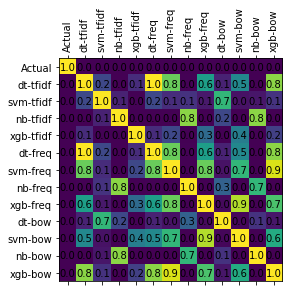

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
dt-tfidf   0.582353    0.500  0.641026  0.414634    0.534503  0.550000
dt-freq    0.588235    0.500  0.641026  0.406504    0.533941  0.417647
xgb-freq   0.611765    0.500  0.538462  0.471545    0.530443  0.588235
xgb-tfidf  0.635294    0.375  0.487179  0.569106    0.516645  0.408824
dt-bow     0.494118    0.500  0.358974  0.439024    0.448029  0.458824
xgb-bow    0.600000    0.125  0.435897  0.504065    0.416241  0.538235
svm-freq   0.682353    0.000  0.589744  0.357724    0.407455  0.476471
svm-bow    0.700000    0.125  0.307692  0.463415    0.399027  0.526471
svm-tfidf  0.600000    0.000  0.666667  0.276423    0.385772  0.526471
nb-bow     0.388235    0.125  0.384615  0.439024    0.334219  0.535294
nb-freq    0.452941    0.000  0.512821  0.365854    0.332904  0.555882
nb-tfidf   0.429412    0.000  0.410256  0.406504    0.311543  0.400000

Mean:

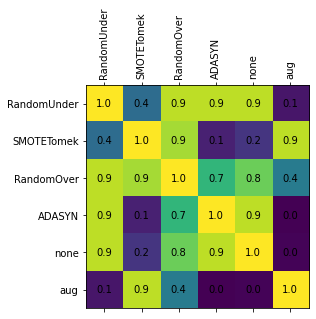

In [13]:
task_eval('type')

In [14]:
def compare_aug(method):
    for task in ['binary', 'type']:
        df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-{method}.csv')
        aug_df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-aug.csv')
        df['Common'] = df.apply(lambda x: mode(np.array(x, dtype=np.int64)), axis=1)
        aug_df['Common'] = aug_df.apply(lambda x: mode(np.array(x, dtype=np.int64)), axis=1)
        result = cochrans_q([df['Common'], aug_df['Common']])
        
        #get row with int correct/incorrect
        aug_columns = list(aug_df.columns.values)
        common, actual = aug_columns.index('Common'), aug_columns.index('Actual')
        aug_df["Correct"] = aug_df.apply(lambda x: int(x[common] == x[actual]), axis=1)
        columns = list(df.columns.values)
        common, actual = columns.index('Common'), columns.index('Actual')
        df["Correct"] = df.apply(lambda x: int(x[common] == x[actual]), axis=1)
        
        print(f'Task: {task}')
        print(f"McNemar's test p-value: {result.pvalue}\n")
        print(f'Augmented mean accuracy: {aug_df["Correct"].mean()}.\nOriginal mean accuracy: {df["Correct"].mean()}.')
        print('\n')

In [15]:
compare_aug('RandomUnder')

Task: binary
McNemar's test p-value: 1.4417979853655802e-31

Augmented mean accuracy: 0.7377049180327869.
Original mean accuracy: 0.7254098360655737.


Task: type
McNemar's test p-value: 0.02419461749781374

Augmented mean accuracy: 0.638235294117647.
Original mean accuracy: 0.46176470588235297.


